In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights
import tensorflow_datasets as tfds

2024-10-14 12:05:41.175017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
from torchvision.datasets import OxfordIIITPet

In [3]:
type(OxfordIIITPet)

type

In [2]:
dir = '/Volumes/KCQDrive/projects'
dataset = 'stanford_dogs'
train_data, train_info = tfds.load(dataset, split='train', shuffle_files=True, data_dir = f"{dir}/tensorflow_datasets/", with_info=True)
test_data, test_info = tfds.load(dataset, split='test', shuffle_files=True, data_dir = f"{dir}/tensorflow_datasets/", with_info=True)

In [3]:
train_info.features["label"].num_classes

120

In [4]:
tfds.as_numpy(train_data)

2024-10-14 12:07:19.823610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


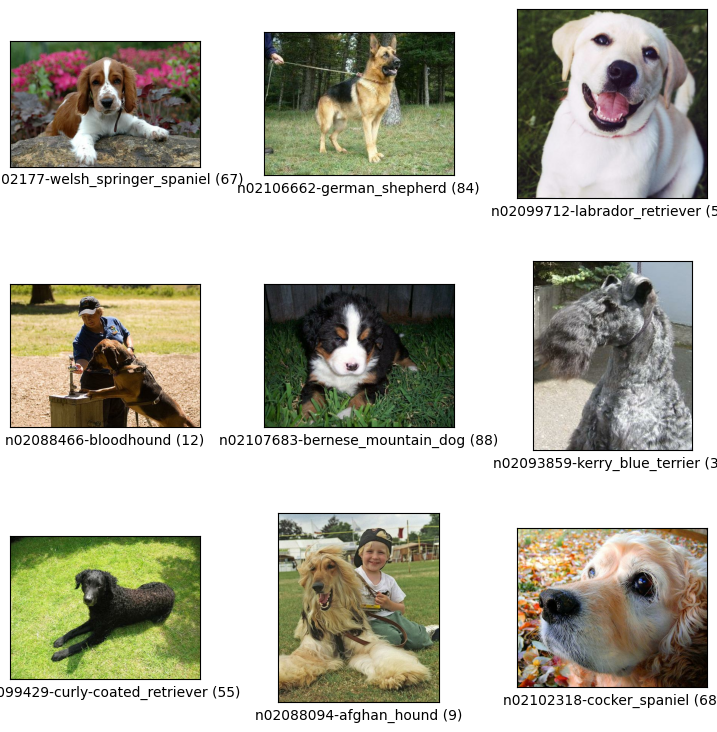

In [5]:
fig = tfds.show_examples(test_data, test_info)

In [125]:
class ObjectDetector():
    def __init__(self, num_classes:int):
        super(ObjectDetector, self).__init__()
        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        self.base_model = nn.Sequential(
            *list(vgg.features.children())
        )
        input_features = nn.Sequential(*list(vgg.classifier.children()))[0].in_features
        self.classifier = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )
        num_coordinates = 4
        self.box_regressor = nn.Sequential(
            nn.Linear(num_coordinates, 32),
            nn.ReLU(),
            nn.Linear(32,num_classes)
        )
    def forward(self, x):
        features = self.base_model(x)
        bboxes = self.box_regressor(features)
        classes = self.classifier(features)
        return bboxes, classes

In [145]:
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import FasterRCNN
import torchvision
import torch
num_breeds = train_info.features["label"].num_classes
# Configure anchor size
anchor_sizes = ((32, 64, 128),)
# Configure aspect ratio
aspect_ratios = ((0.5,1.0,2.0),)
anchor_generator = AnchorGenerator(anchor_sizes,aspect_ratios)
roi_pooler = MultiScaleRoIAlign(
    featmap_names=["0"],
    output_size=7,
    sampling_ratio=2
)


base_model = torchvision.models.mobilenet_v2(weights="DEFAULT").features
base_model.out_channels = 1280

model = FasterRCNN(
    backbone=base_model,
    num_classes=num_breeds,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

# Implement the R-CNN classification Loss function
rcnn_cls_criterion = nn.CrossEntropyLoss()
# Implement the R-CNN regression loss function
rcnn_reg_criterion = nn.MSELoss()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 3
for epoch in range(epochs):
    cls_running_loss = 0.0
    # Iterate over training batches
    for images, labels in iter(list(train_loader)):
        optimizer.zero_grad()
        outputs = model(images)
        loss = rcnn_cls_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        cls_running_loss += loss.item()
    epoch_loss = cls_running_loss / len(train_data)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

TypeError: '_PrefetchDataset' object is not subscriptable

In [152]:
import torch
from torchvision import transforms
from PIL import Image
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1)
        # Define the decoder blocks
        self.dec1 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec3 = self.conv_block(128, 64)
        self.out = nn.Conv2d(64, out_channels, kernel_size=2)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        x = self.upconv3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.dec1(x)
        x = self.upconv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)
        # Define the last decoder block with skip connections
        x = self.upconv1(x)
        x = torch.cat([x,x4], dim=1)
        x = self.dec3(x)
        return self.out(x)



In [149]:
# Load and transform image
image = Image.open("/Users/kristinaqualben/Downloads/jason-segel.jpeg")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
    ])
image_tensor = transform(image).unsqueeze(0)
image_tensor.shape

torch.Size([1, 3, 128, 128])

In [150]:
transform(image).squeeze(0).permute(1,2,0).shape

torch.Size([128, 128, 3])

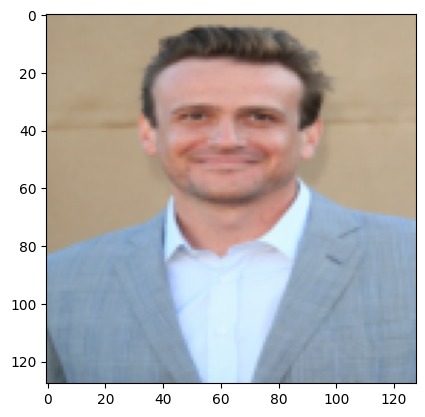

In [83]:
# Load and transform image
image = Image.open("/Users/kristinaqualben/Downloads/jason-segel.jpeg")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
    ])
image_tensor = transform(image).unsqueeze(0)
#image_tensor = transform(image).squeeze(0).permute(1,2,0)
plt.imshow(transform(image).squeeze(0).permute(1,2,0))
plt.show()

In [153]:
# Load model
model = UNet(in_channels=3,out_channels=3)
model.eval()
# Predict segmentation mask
with torch.no_grad():
   prediction = model(image_tensor).squeeze(0)
# Display mask
plt.imshow(prediction[1, :, :])
plt.show()

RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small

In [ ]:
# Instantiate the model
model = UNet()
# Produce semantic masks for the input image
with torch.no_grad():
   semantic_masks = model(image_tensor)
# Choose highest-probability class for each pixel
semantic_mask = torch.argmax(semantic_masks, dim=1)
# Display the mask
plt.imshow(semantic_mask.squeeze(0))
plt.axis("off")
plt.show()

In [ ]:
model = UNet()
# Produce semantic masks for the input image
with torch.no_grad():
   semantic_masks = model(image_tensor)
# Choose highest-probability class for each pixel
semantic_mask = torch.argmax(semantic_masks, dim=1)
# Display the mask
plt.imshow(semantic_mask.squeeze(0))
plt.axis("off")
plt.show()

In [89]:
# Dataloaders

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

print("Train batches:", len(train_loader))
print("Test batches:",len(test_loader))

Train batches: 188
Test batches: 135


In [151]:
class R50_encoder(torch.nn.Module):
    def __init__(self,weights, freeze_weights):
        super(R50_encoder, self).__init__()

        # Load the ResNet50 model
        self.resnet = torchvision.models.resnet50(weights=weights)
        
        # Freezing the weights of the encoder
        if freeze_weights:
            for param in self.resnet.parameters():
                param.requires_grad = False
                
        # Remove the last linear layer
        self.layers = torch.nn.Sequential(*list(self.resnet.children())[:-1])


    def forward(self, x):
        outputs = self.layers(x)
        return outputs

In [97]:
def get_features(encoder,dataloader, device):
    features_arr =[]
    labels_arr = []
    
    # switch to the evaluation mode
    encoder.eval()
    
    for images, labels in next(dataloader):
            # load the images to GPU
            images = images.to(device)
            
            features = encoder(images)
            features = features.view(features.shape[0],-1).detach().cpu().numpy()
            
            features_arr.append(features)
            labels_arr.append(labels)
   
    # combine batches
    features_arr = np.concatenate(features_arr, axis=0)
    labels_arr = np.concatenate(labels_arr, axis=0)

    return features_arr, labels_arr

In [93]:

weights = torchvision.models.resnet.ResNet34_Weights.DEFAULT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = R50_encoder(weights = weights, freeze_weights=True)
encoder = encoder.to(torch.float32)
encoder = encoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/kristinaqualben/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 58.9MB/s]


In [98]:
x_train,y_train = get_features(encoder,train_loader, device)
x_test, y_test = get_features(encoder,test_loader, device)

TypeError: 'DataLoader' object is not an iterator

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

grid = {'n_neighbors': [i for i in range(1,15)]}

knn_classifier = KNeighborsClassifier(metric='euclidean')

grid_search = GridSearchCV(knn_classifier, grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

k = grid_search.best_params_['n_neighbors']

print("Best K:", grid_search.best_params_)

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn_classifier.fit(x_train, y_train)

preds = knn_classifier.predict(x_test)

accuracy = accuracy_score(y_test, preds, normalize=True)
print(f"Accuracy: {(100*accuracy):.3f}%")

In [ ]:
cm = confusion_matrix(y_test, preds, labels=knn_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn_classifier.classes_)

fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.show()

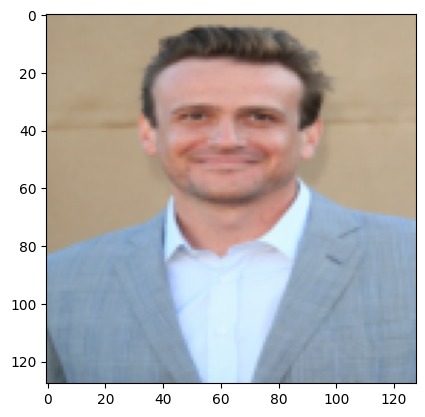

In [99]:
# Load and transform image
image = Image.open("/Users/kristinaqualben/Downloads/jason-segel.jpeg")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
    ])
image_tensor = transform(image).unsqueeze(0)
#image_tensor = transform(image).squeeze(0).permute(1,2,0)
plt.imshow(transform(image).squeeze(0).permute(1,2,0))
plt.show()

In [100]:
train_transforms = transforms.Compose([
   transforms.RandomHorizontalFlip(),
   transforms.RandomRotation(45),
   transforms.RandomAutocontrast(),
   transforms.ToTensor(),
   transforms.Resize((64,64)),
])
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

In [111]:
len(dataloader_train)

750